# Multilabel Classification on a Diabetes Dataset

Goal statement: I use the diabetes_data.csv dataset from Kaggle.com [1] to perform multilabel classification by predicting whether the patient has diabetes, stroke, and high blood pressure using Keras's Functional API. This is a multilabel, binary classification problem.

In [1]:
# Libraries and imports
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
# model with unedited dataset
raw_ANN = keras.models.load_model('multilabel_clf_unengineered.h5')
# model with BMI categorized and One-Hot encoded
# ANN_BMI_cats = keras.models.load_model('ANN_with_BMI_cats.h5')

In [30]:
# Read data
data = pd.read_csv(r'C:\Users\linda\OneDrive\Desktop\diabetes_data.csv')

data.head()
# data.shape

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


I already created an Artificial Neural Network model that keeps the BMI as a continuous feature. It will be loaded for comparison against model with BMI as categories.

Feature Engineering:
 - Cut the BMI feature into categories
  - BMI was converted into categories based on the CDC article "Defining Adult Overweight & Obesity" [2].
 - Convert the features' categories into One-Hot encoded features
  - The Age feature is already categorized as 1-13 (see metadata in [1]); it just needs One-Hot encoding.
 - Add to new dataset and rename columns

In [32]:
# Cut BMI feature into categories for One-Hot encoding
BMI_cuts = pd.cut(x=data['BMI'], bins = [0,18.5,24.9,29.9,34.9,39.9,np.inf],
             labels = list(range(6)))

# One hot encoding with .get_dummies() function
BMI_dummies = pd.get_dummies(BMI_cuts, drop_first=True)


# Add the one-hot encoded features to the original dataset
# with the original BMI feature dropped
data = pd.concat([data.drop('BMI', axis = 1), BMI_dummies], axis=1)


# Renaming BMI weight for clarity
data.rename(columns = {0:'underW', 1:'healthyW', 2:'overW', 3:'obsC1',
                      4:'obsC1', 5:'obsC2'}, inplace = True)

# Create lists of target labels for usage later
TARGET_LABELS = ['Stroke','HighBP','Diabetes']

In [6]:
# One-Hot Encode Age feature
# AGE_dummies = pd.get_dummies(data['Age'], drop_first=True)

# data = pd.concat([data.drop('Age', axis = 1), AGE_dummies], axis=1)

In [33]:
# Convert dataframe subsets to numpy arrays
X = data.drop(['Stroke','HighBP','Diabetes'], axis = 1).to_numpy() # Predictors
y = data[['Stroke','HighBP','Diabetes']].to_numpy()                # 3 targets, binary

In [34]:
# Split into training and testing sets
# Sets will by further split into validation, next
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training set into validation set
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


# print(X_valid.shape)
# print(X_train.shape)
# print(y_valid.shape)
# print(y_train.shape)

Because I'm creating and evaluating models, then engineering features, then repeating, the ANN hyperparameters will be stored in variables as the layer sizes will change accordingly to the number of features.

In [49]:
# Number of input features; the number of features for any observation


# Creating sequential model
m = keras.models.Sequential([
 keras.layers.InputLayer(19),                       # One input node per feature, n
 keras.layers.Dense(19*19*19, activation="relu"),   # n^3 nodes
 keras.layers.Dense(19*19, activation="relu"),      # n^2 nodes
 keras.layers.Dense(3, activation="sigmoid")        # one output node per label
])

In [50]:
X_valid[0].shape

(19,)

In [51]:
# Model summary to inspect number of connections
m.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6859)              137180    
_________________________________________________________________
dense_25 (Dense)             (None, 361)               2476460   
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 1086      
Total params: 2,614,726
Trainable params: 2,614,726
Non-trainable params: 0
_________________________________________________________________


In [52]:
m.compile(loss="binary_crossentropy", # For binary classification
 optimizer="sgd",                     # SGD
 metrics=["accuracy"])                # Display accuracy

In [53]:
history = m.fit(X_train, y_train, epochs=30,
                     validation_data=(X_valid, y_valid))

Epoch 1/30
1612/1612 [==============================] - 18s 11ms/step - loss: 0.4818 - accuracy: 0.4489 - val_loss: 1.3596 - val_accuracy: 0.4294
Epoch 2/30
1612/1612 [==============================] - 19s 11ms/step - loss: 0.4448 - accuracy: 0.4357 - val_loss: 0.5258 - val_accuracy: 0.3378
Epoch 3/30
1612/1612 [==============================] - 18s 11ms/step - loss: 0.4347 - accuracy: 0.4367 - val_loss: 0.4628 - val_accuracy: 0.4174
Epoch 4/30
1612/1612 [==============================] - 19s 12ms/step - loss: 0.4311 - accuracy: 0.4374 - val_loss: 0.5505 - val_accuracy: 0.3420
Epoch 5/30
1612/1612 [==============================] - 19s 12ms/step - loss: 0.4289 - accuracy: 0.4375 - val_loss: 0.5103 - val_accuracy: 0.4592
Epoch 6/30
1612/1612 [==============================] - 20s 12ms/step - loss: 0.4266 - accuracy: 0.4371 - val_loss: 0.4582 - val_accuracy: 0.4988
Epoch 7/30
1612/1612 [==============================] - 20s 12ms/step - loss: 0.4252 - accuracy: 0.4396 - val_loss: 0.4311 -

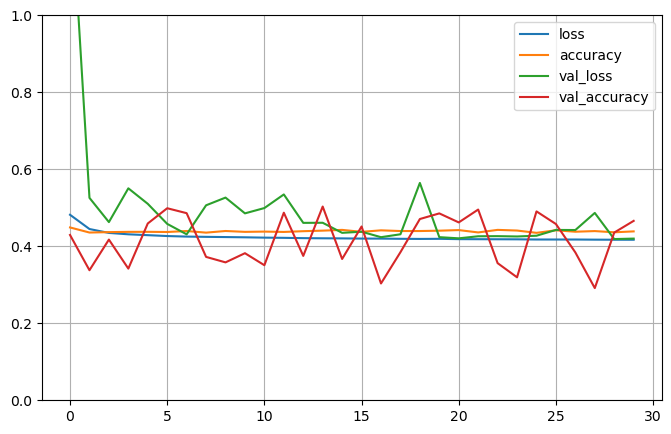

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

We see that the loss and accuracy converge without reaching a good solution. We will convert the `Age` feature into categories after looking at predictions.

Load the model with the unedited dataset.

In [55]:
# Predictions, outputs probabilities for current model
predictions_matrix_probs = m.predict(X_valid)

# Predictions, outputs probabilities for unengineered
# X_valid[:,:15] takes only the first 15 features
predictions_matrix_probs2 = raw_ANN.predict(X_valid[:,:15])

In [56]:
print(predictions_matrix_probs[:2])
print(predictions_matrix_probs2[:2])

[[0.0336999  0.62301254 0.64846146]
 [0.35543337 0.8639597  0.8187064 ]]
[[0.427373   0.4163969  0.2738595 ]
 [0.20985916 0.3225986  0.13661423]]


In [57]:
# LIST COMPREHENSION
# to convert probabilities into binary decision
# 1 if the vector index is >= .5, else put 0
# For each vector in the prediction matrix
predictions_matrix_bin = np.array([[1 if i >= .5 else 0 for i in vector] \
                          for vector in predictions_matrix_probs])

predictions_matrix_bin2 = np.array([[1 if i >= .5 else 0 for i in vector] \
                          for vector in predictions_matrix_probs2])

In [17]:
# Printing the confusion matrices, one for each label
for i in range(len(TARGET_LABELS)):
    print(f"CONFUSION MATRIX for {TARGET_LABELS[i]}:")
    print("____________________________")
    print(multilabel_confusion_matrix(predictions_matrix_bin, y_valid)[i],end = '\n'*2)

CONFUSION MATRIX for Stroke:
____________________________
[[4701  299]
 [   0    0]]

CONFUSION MATRIX for HighBP:
____________________________
[[1458  596]
 [ 784 2162]]

CONFUSION MATRIX for Diabetes:
____________________________
[[1837  726]
 [ 651 1786]]



In [18]:
for i in range(len(TARGET_LABELS)):
    print(f"CONFUSION MATRIX for {TARGET_LABELS[i]}:")
    print("____________________________")
    print(multilabel_confusion_matrix(predictions_matrix_bin2, y_valid)[i],end = '\n'*2)

CONFUSION MATRIX for Stroke:
____________________________
[[3370  142]
 [1331  157]]

CONFUSION MATRIX for HighBP:
____________________________
[[1930 2067]
 [ 312  691]]

CONFUSION MATRIX for Diabetes:
____________________________
[[2209 1930]
 [ 279  582]]



In [ ]:
m.save('ANN_with_BMI_cats.h5')

References:

[1] https://www.kaggle.com/datasets/prosperchuks/health-dataset

[2] https://www.cdc.gov/obesity/basics/adult-defining.html

[3] https://apps.who.int/gho/data/node.searo-metadata.AGEGROUP?lang=en